In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

import sys
sys.path.append("..")
from dgp import DGP_RF
from likelihoods import Gaussian

In [7]:
def get_step_data(num_training, num_testing, std_noise=0.01, gap=-0.1):
    num_low = num_training // 2
    num_high = num_training - num_low
    X_train = np.vstack((np.linspace(-1, -gap/2.0, num_low)[:, np.newaxis],
              np.linspace(gap/2.0, 1, num_high)[:, np.newaxis]))
    y = np.vstack((np.zeros((num_low, 1)), np.ones((num_high,1))))
    scale = np.sqrt(y.var())
    offset = y.mean()
    Y_train = (y-offset)/scale
    
    X_test = np.linspace(-2., 2., num_testing)[:, None]
    
    return X_train, Y_train, X_test

In [3]:
class ToyRegressionDGP(DGP_RF):
    def __init__(self, d_in, d_out, n_hidden_layers=1, n_rf=20, n_gp=2, likelihood=Gaussian(),
                 kernel_list=None, random_fixed=True, name=None):
        super(ToyRegressionDGP, self).__init__(d_in, d_out, n_hidden_layers=n_hidden_layers,
                                            n_rf=n_rf, n_gp=n_gp,
                                            likelihood=likelihood, kernel_list=kernel_list,
                                            random_fixed=random_fixed, name=name)

    def feed_forward(self, X):
        X = tf.constant(X, tf.float32)
        # output mean because of the Gaussian likelihood in the final layer
        out = self.BNN(X)
        return out
    
    def feed_forward_all_layers(self, X):
        X = tf.constant(X, dtype=tf.float32)
        output_list = []
        for l, layer in enumerate(self.BNN.layers):
            X = layer(X)
            if l % 2 == 1:
                output_list.append(X)
        return output_list

    def adjust_traditional_learning_rate(self, epoch, lr_0=0.1, dtype=tf.float32):
        epoch = tf.cast(epoch, dtype)
        lr = lr_0
#         lr = 0.5 * (1. + epoch) ** (-0.5) * lr_0
        return lr

    def adjust_cyclical_learning_rate(self, k, K, M=1, lr_0=0.1):
        """
        using cyclical lr schedule
        :param k: current iteration index
        :param K: total iterations
        :param M: Number of cycles
        :param lr_0: initial learning rate
        """
        cos_inner = tf.constant(np.pi) / (K // M) * (k % (K // M))
        cos_out = tf.math.cos(cos_inner) + 1
        lr = 0.5 * lr_0 * cos_out
        return lr

Metal device set to: Apple M1 Pro


2022-06-11 22:54:30.714901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-11 22:54:30.715618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


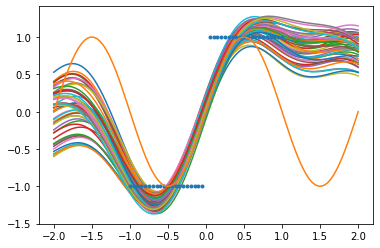

In [8]:
num_training = 40
num_testing = 100
std_noise = 0.1

X_train, Y_train, X_test = get_step_data(num_training, num_testing, gap=0.1, std_noise=std_noise)

d_in = 1
d_out =1
# kernel_list =

model = ToyRegressionDGP(d_in, d_out, n_hidden_layers=1, n_rf=50, n_gp=1, likelihood=Gaussian(),
                         kernel_list=None, random_fixed=True)

num_mixing_epoches = 300
num_samples = 50
eta = 0.9

out_samples = []
for epoch in range(num_mixing_epoches + num_samples):
    lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.1)
    if epoch < num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        out = model.feed_forward(X_test)
        out_samples.append(out)

out_samples = tf.concat(out_samples, axis=-1).numpy() #[N, num_samples]
# print(out_samples)


plt.plot(X_test, out_samples)
plt.plot(X_train[:,0], Y_train[:,0], ".")
# plt.savefig("sin-1-layer.png")

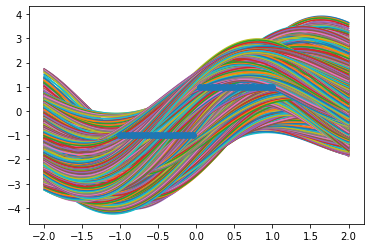

In [12]:
num_training = 40
num_testing = 100
std_noise = 0.1

X_train, Y_train, X_test = get_step_data(num_training, num_testing, gap=0.1, std_noise=std_noise)
d_in = 1
d_out =1
# kernel_list =

model = ToyRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=30, n_gp=[1,1], likelihood=Gaussian(),
                         kernel_list=None, random_fixed=True)

num_mixing_epoches = 400
num_samples = 4000
eta = 0.1

out_samples = []
for epoch in range(num_mixing_epoches + num_samples):
    lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.1)
    if epoch < num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        out = model.feed_forward_all_layers(X_test)
        out_samples.append(out)

out_hid_list = []
out_list = []
for sample in out_samples:
    out_hid = sample[0]
    out_hid_list.append(out_hid)
    out_final = sample[1]
    out_list.append(out_final)

out_hid_list = tf.concat(out_hid_list, axis=-1).numpy() #[N, num_samples]
out_list = tf.concat(out_list, axis=-1).numpy()

plt.plot(X_test, out_hid_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")

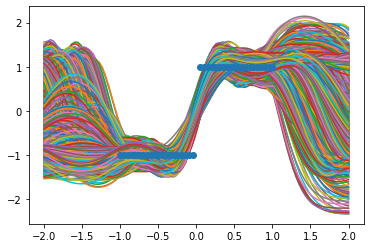

In [13]:
plt.plot(X_test, out_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")
# plt.savefig('sin-2-layers.png')

Number of training data: 94


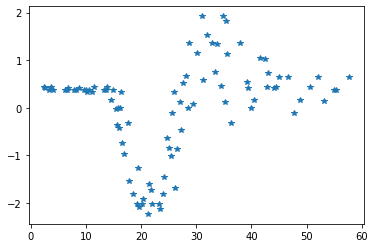

In [19]:
import pods
def get_mcycle_data(num_testing=100):
    data = pods.datasets.mcycle()
    X_train = data['X']
    y = data['Y']
    scale=np.sqrt(y.var())
    offset=y.mean()
    Y_train = (y - offset)/scale
    
    X_test = np.linspace(-20., 80., num_testing)[:, None]
    
    return X_train, Y_train, X_test

X_train, Y_train, X_test = get_mcycle_data()
print(f"Number of training data: {np.shape(X_train)[0]}")
plt.plot(X_train[:,0], Y_train[:,0], "*")

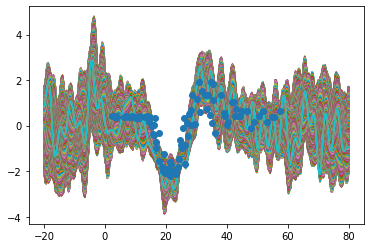

In [22]:
num_training = 94
num_testing = 300

X_train, Y_train, X_test = get_mcycle_data(num_testing=num_testing)

d_in = 1
d_out =1
# kernel_list =

model = ToyRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=30, n_gp=[1,1], likelihood=Gaussian(),
                         kernel_list=None, random_fixed=True)

num_mixing_epoches = 400
num_samples = 5000
eta = 0.1

out_samples = []
for epoch in range(num_mixing_epoches + num_samples):
    lr = model.adjust_traditional_learning_rate(epoch, lr_0=0.1)
    if epoch < num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
    elif epoch >= num_mixing_epoches:
        model.sghmc_update(X_train, Y_train, lr, num_training, eta=eta, temperature=1.)
        out = model.feed_forward_all_layers(X_test)
        out_samples.append(out)

out_hid_list = []
out_list = []
for sample in out_samples:
    out_hid = sample[0]
    out_hid_list.append(out_hid)
    out_final = sample[1]
    out_list.append(out_final)

out_hid_list = tf.concat(out_hid_list, axis=-1).numpy() #[N, num_samples]
out_list = tf.concat(out_list, axis=-1).numpy()

plt.plot(X_test, out_hid_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")

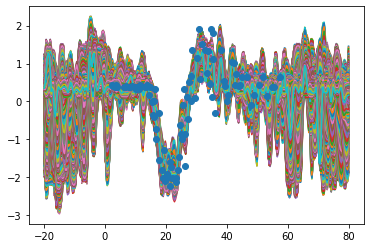

In [23]:
plt.plot(X_test, out_list)
plt.plot(X_train[:,0], Y_train[:,0], "o")
# plt.savefig('sin-2-layers.png')